# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array([
    'airplane', 'automobile ', 'bird ', 'cat ', 'deer ', 'dog ', 'frog ',
    'horse ', 'ship ', 'truck'
])

print(X_train.shape, y_train.shape)

(40000, 3, 32, 32) (40000,)


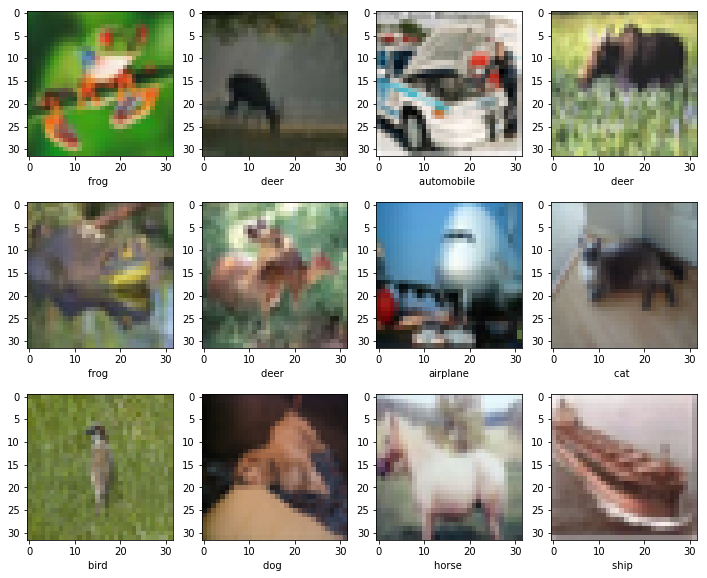

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12, 10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i], [1, 2, 0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [55]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [4]:
def compute_loss(model, X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(model, X_train[:5], y_train[:5])

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [5]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start:start + batchsize]
        yield X[ix], y[ix]

In [56]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [58]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(model, X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy()[0])
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 1.056s
  training loss (in-iteration): 	2.027064
  validation accuracy: 			35.15 %
Epoch 2 of 100 took 1.057s
  training loss (in-iteration): 	1.854894
  validation accuracy: 			37.19 %
Epoch 3 of 100 took 1.024s
  training loss (in-iteration): 	1.787962
  validation accuracy: 			37.83 %
Epoch 4 of 100 took 1.020s
  training loss (in-iteration): 	1.743586
  validation accuracy: 			40.19 %
Epoch 5 of 100 took 1.033s
  training loss (in-iteration): 	1.709104
  validation accuracy: 			40.88 %
Epoch 6 of 100 took 1.162s
  training loss (in-iteration): 	1.676199
  validation accuracy: 			41.94 %
Epoch 7 of 100 took 1.036s
  training loss (in-iteration): 	1.648104
  validation accuracy: 			42.64 %
Epoch 8 of 100 took 1.264s
  training loss (in-iteration): 	1.622509
  validation accuracy: 			42.96 %
Epoch 9 of 100 took 1.027s
  training loss (in-iteration): 	1.602325
  validation accuracy: 			43.93 %
Epoch 10 of 100 took 1.057s
  training loss (in-iteration): 	1.583886
  v

KeyboardInterrupt: 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [59]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		49.33 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [47]:
model1 = nn.Sequential()

model1.add_module('conv1',
                 nn.Conv2d(in_channels=3, out_channels=10,
                           kernel_size=3))  # convolution
model1.add_module('pool1', nn.MaxPool2d(2))  # max pooling 2x2
model1.add_module('relu1', nn.ReLU())  # max pooling 2x2

# reshape from "images" to flat vectors
model1.add_module('flatten', Flatten())

# dense "head"
model1.add_module('dense1', nn.Linear(10 * 15 * 15, 100))
model1.add_module('dense1_dropout', nn.Dropout(p=0.1))
model1.add_module('dense1_relu', nn.ReLU())
model1.add_module('dense2_logits', nn.Linear(100, 10))  # logits for 10 classes

In [48]:
opt = torch.optim.Adam(model1.parameters())

train_loss = []
val_accuracy = []

In [49]:
import time
num_epochs = 100  # total amount of full passes over training data
batch_size = 50  # number of samples processed in one ADAM iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model1.train(True)  # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(model1, X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy()[0])

    # And a full pass over the validation data:
    model1.train(False)  # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model1(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs,
                                               time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size:])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100))

Epoch 1 of 100 took 13.087s
  training loss (in-iteration): 	1.785173
  validation accuracy: 			43.77 %
Epoch 2 of 100 took 16.519s
  training loss (in-iteration): 	1.519774
  validation accuracy: 			49.56 %
Epoch 3 of 100 took 15.760s
  training loss (in-iteration): 	1.403970
  validation accuracy: 			52.39 %
Epoch 4 of 100 took 14.941s
  training loss (in-iteration): 	1.319121
  validation accuracy: 			54.71 %
Epoch 5 of 100 took 14.292s
  training loss (in-iteration): 	1.270010
  validation accuracy: 			56.39 %
Epoch 6 of 100 took 15.546s
  training loss (in-iteration): 	1.221450
  validation accuracy: 			57.52 %
Epoch 7 of 100 took 15.101s
  training loss (in-iteration): 	1.187475
  validation accuracy: 			58.23 %
Epoch 8 of 100 took 14.143s
  training loss (in-iteration): 	1.156184
  validation accuracy: 			59.09 %
Epoch 9 of 100 took 15.172s
  training loss (in-iteration): 	1.127316
  validation accuracy: 			59.21 %
Epoch 10 of 100 took 15.382s
  training loss (in-iteration): 	1.

KeyboardInterrupt: 

In [50]:
model1.train(False)  # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model1(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		60.04 %
Achievement unlocked: 70lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [51]:
model2 = nn.Sequential()

model2.add_module('conv1',
                  nn.Conv2d(in_channels=3, out_channels=10,
                            kernel_size=3))  # convolution
model2.add_module('conv1_maxpool', nn.MaxPool2d(2))  # max pooling 2x2
model2.add_module(
    'conv1_bn',
    nn.BatchNorm2d(10))  # 10 output channels get normalized on the 2D grid
model2.add_module('conv1_relu', nn.ReLU())  # nonlinearity after maxpool

# reshape from "images" to flat vectors
model2.add_module('flatten', Flatten())

# dense "head"
model2.add_module('dense1', nn.Linear(10 * 15 * 15, 100))
model2.add_module('dense1_bn', nn.BatchNorm1d(100))
model2.add_module('dense1_relu', nn.ReLU())
model2.add_module('dense1_dropout', nn.Dropout(p=0.1))
model2.add_module('dense2_logits', nn.Linear(100, 10))  # logits for 10 classes

In [52]:
opt = torch.optim.Adam(model2.parameters())

train_loss = []
val_accuracy = []
compute_loss(model2, X_train[:5], y_train[:5])

Variable containing:
 2.3578
[torch.FloatTensor of size 1]

In [53]:
import time
num_epochs = 100  # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model2.train(True)  # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(model2, X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy()[0])

    # And a full pass over the validation data:
    model2.train(False)  # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model2(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs,
                                               time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size:])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100))

Epoch 1 of 100 took 11.220s
  training loss (in-iteration): 	1.422913
  validation accuracy: 			57.76 %
Epoch 2 of 100 took 11.330s
  training loss (in-iteration): 	1.122347
  validation accuracy: 			56.06 %
Epoch 3 of 100 took 12.724s
  training loss (in-iteration): 	1.008369
  validation accuracy: 			63.40 %
Epoch 4 of 100 took 12.515s
  training loss (in-iteration): 	0.916005
  validation accuracy: 			62.86 %
Epoch 5 of 100 took 13.708s
  training loss (in-iteration): 	0.840065
  validation accuracy: 			64.70 %
Epoch 6 of 100 took 11.627s
  training loss (in-iteration): 	0.772606
  validation accuracy: 			63.95 %
Epoch 7 of 100 took 11.579s
  training loss (in-iteration): 	0.715555
  validation accuracy: 			62.31 %
Epoch 8 of 100 took 11.038s
  training loss (in-iteration): 	0.660058
  validation accuracy: 			60.26 %
Epoch 9 of 100 took 15.055s
  training loss (in-iteration): 	0.616604
  validation accuracy: 			63.47 %
Epoch 10 of 100 took 14.918s
  training loss (in-iteration): 	0.

KeyboardInterrupt: 

In [54]:
model2.train(False)  # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model2(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		61.48 %
Achievement unlocked: 70lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X: <class 'torch.FloatTensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.LongTensor'> torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NotImplementedError: Plese use this code in your training loop

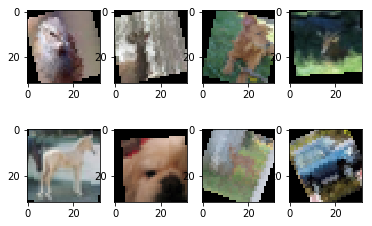

In [24]:
for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)

    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img.transpose([1, 2, 0]) * stds + means)

    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [42]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

train_loader = CIFAR10(
    "./cifar_data/", train=True, transform=transform_augment)

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

train_idx, val_idx = train_test_split(
    np.arange(len(train_loader)), test_size=0.2)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_batch_gen = torch.utils.data.DataLoader(
    train_loader, batch_size=50, num_workers=1, sampler=train_sampler)

# set_trace()
num_val = val_idx.shape[0]
val_batch_gen = torch.utils.data.DataLoader(
    train_loader, batch_size=50, num_workers=1, sampler=val_sampler)

test_batch_gen = torch.utils.data.DataLoader(
    test_loader, num_workers=1, batch_size=50, shuffle=False)

In [43]:
model3 = nn.Sequential()

model3.add_module('conv1',
                  nn.Conv2d(in_channels=3, out_channels=10,
                            kernel_size=3))  # convolution
model3.add_module('conv1_maxpool', nn.MaxPool2d(2))  # max pooling 2x2
model3.add_module(
    'conv1_bn',
    nn.BatchNorm2d(10))  # 10 output channels get normalized on the 2D grid
model3.add_module('conv1_relu', nn.ReLU())  # nonlinearity after maxpool

# reshape from "images" to flat vectors
model3.add_module('flatten', Flatten())

# dense "head"
model3.add_module('dense1', nn.Linear(10 * 15 * 15, 100))
model3.add_module('dense1_bn', nn.BatchNorm1d(100))
model3.add_module('dense1_relu', nn.ReLU())
model3.add_module('dense1_dropout', nn.Dropout(p=0.1))
model3.add_module('dense2_logits', nn.Linear(100, 10))  # logits for 10 classes

In [44]:
opt = torch.optim.Adam(model3.parameters())

train_loss = []
val_accuracy = []
compute_loss(model3, X_train[:5], y_train[:5])

Variable containing:
 2.2844
[torch.FloatTensor of size 1]

In [45]:
from IPython.core.debugger import set_trace
import time
num_epochs = 100  # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model3.train(True)  # enable dropout / batch_norm training behavior
    for (x_batch, y_batch) in train_batch_gen:
        loss = compute_loss(model3, x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy()[0])

    # And a full pass over the validation data:
    model3.train(False)  # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model3(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        #         set_trace()
        val_accuracy.append(np.mean(y_batch.numpy() == y_pred))

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs,
                                               time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size:])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100))

Epoch 1 of 100 took 15.480s
  training loss (in-iteration): 	1.705827
  validation accuracy: 			44.56 %
Epoch 2 of 100 took 16.059s
  training loss (in-iteration): 	1.523638
  validation accuracy: 			47.72 %
Epoch 3 of 100 took 15.645s
  training loss (in-iteration): 	1.472052
  validation accuracy: 			48.26 %
Epoch 4 of 100 took 15.957s
  training loss (in-iteration): 	1.441103
  validation accuracy: 			50.27 %
Epoch 5 of 100 took 16.570s
  training loss (in-iteration): 	1.410153
  validation accuracy: 			50.31 %
Epoch 6 of 100 took 16.224s
  training loss (in-iteration): 	1.395674
  validation accuracy: 			51.36 %
Epoch 7 of 100 took 16.467s
  training loss (in-iteration): 	1.381549
  validation accuracy: 			52.86 %
Epoch 8 of 100 took 15.752s
  training loss (in-iteration): 	1.368835
  validation accuracy: 			53.27 %
Epoch 9 of 100 took 15.800s
  training loss (in-iteration): 	1.348448
  validation accuracy: 			54.33 %
Epoch 10 of 100 took 15.453s
  training loss (in-iteration): 	1.

Epoch 80 of 100 took 13.786s
  training loss (in-iteration): 	1.165925
  validation accuracy: 			60.99 %
Epoch 81 of 100 took 14.535s
  training loss (in-iteration): 	1.164542
  validation accuracy: 			61.09 %
Epoch 82 of 100 took 14.224s
  training loss (in-iteration): 	1.172322
  validation accuracy: 			60.10 %
Epoch 83 of 100 took 17.406s
  training loss (in-iteration): 	1.167616
  validation accuracy: 			61.03 %
Epoch 84 of 100 took 15.555s
  training loss (in-iteration): 	1.165361
  validation accuracy: 			61.21 %
Epoch 85 of 100 took 19.351s
  training loss (in-iteration): 	1.171592
  validation accuracy: 			60.66 %
Epoch 86 of 100 took 16.296s
  training loss (in-iteration): 	1.166515
  validation accuracy: 			61.33 %
Epoch 87 of 100 took 16.858s
  training loss (in-iteration): 	1.164758
  validation accuracy: 			61.13 %
Epoch 88 of 100 took 15.840s
  training loss (in-iteration): 	1.162717
  validation accuracy: 			61.96 %
Epoch 89 of 100 took 15.064s
  training loss (in-iterat

In [46]:
model3.train(False)  # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model3(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch.numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		65.07 %
Achievement unlocked: 70lvl Warlock!


## The Quest For A Better Network

See `practical_dl/homework02` for a full-scale assignment.